# Session 4: Statistical Inference I - Parametric Tests

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Understand the assumptions underlying parametric event study tests
2. Implement and interpret the standard t-test for event studies
3. Apply the Patell (1976) standardized residual test
4. Use the Boehmer, Musumeci, and Poulsen (1991) test for event-induced variance
5. Distinguish between cross-sectional and time-series variance approaches
6. Evaluate the power and specification of different test statistics

---

## 1. Introduction: The Inference Problem

### From Measurement to Inference

In Session 3, we learned how to measure abnormal returns. But measurement alone doesn't tell us whether the event had a **statistically significant** effect. We need formal hypothesis tests.

### The Null Hypothesis

$$H_0: E[AR_{i,t}] = 0 \quad \text{(No abnormal return)}$$
$$H_1: E[AR_{i,t}] \neq 0 \quad \text{(Significant event effect)}$$

### Key Challenges

1. **Estimation error**: Parameters ($\alpha$, $\beta$) are estimated, not known
2. **Cross-sectional correlation**: Events may cluster in calendar time
3. **Event-induced variance**: The event itself may change volatility
4. **Non-normality**: Returns are often fat-tailed
5. **Small samples**: Limited number of events in many studies

This session focuses on **parametric tests** that assume (approximately) normal distributions. Session 5 will cover non-parametric alternatives.

## 2. Setup and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import comb
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# We'll use a larger sample for better demonstration of test properties
EVENTS = [
    # Tech earnings Q2-Q3 2023
    {'ticker': 'AAPL', 'date': '2023-08-03', 'name': 'Apple Q3'},
    {'ticker': 'MSFT', 'date': '2023-07-25', 'name': 'Microsoft Q4'},
    {'ticker': 'GOOGL', 'date': '2023-07-25', 'name': 'Alphabet Q2'},
    {'ticker': 'AMZN', 'date': '2023-08-03', 'name': 'Amazon Q2'},
    {'ticker': 'META', 'date': '2023-07-26', 'name': 'Meta Q2'},
    {'ticker': 'NVDA', 'date': '2023-08-23', 'name': 'Nvidia Q2'},
    {'ticker': 'TSLA', 'date': '2023-07-19', 'name': 'Tesla Q2'},
    {'ticker': 'AMD', 'date': '2023-08-01', 'name': 'AMD Q2'},
    {'ticker': 'INTC', 'date': '2023-07-27', 'name': 'Intel Q2'},
    {'ticker': 'CRM', 'date': '2023-08-30', 'name': 'Salesforce Q2'},
]

ESTIMATION_WINDOW = 120
GAP = 10
EVENT_WINDOW_PRE = 10
EVENT_WINDOW_POST = 10

print(f"Sample: {len(EVENTS)} tech earnings announcements")

Sample: 10 tech earnings announcements


In [5]:
@dataclass
class MarketModelResults:
    """Container for market model estimation results."""
    alpha: float
    beta: float
    sigma: float
    r_squared: float
    n_obs: int
    market_mean: float
    market_var: float
    residuals: np.ndarray


@dataclass 
class EventStudyResult:
    """Container for single event study results."""
    ticker: str
    name: str
    event_date: pd.Timestamp
    model: MarketModelResults
    event_data: pd.DataFrame
    estimation_data: pd.DataFrame


def download_and_process_event(ticker: str, event_date: str, name: str,
                                est_window: int, gap: int, 
                                pre: int, post: int) -> Optional[EventStudyResult]:
    """
    Download data and estimate market model for a single event.
    """
    try:
        event_dt = pd.to_datetime(event_date)
        start_date = event_dt - timedelta(days=int((est_window + gap + pre) * 1.5))
        end_date = event_dt + timedelta(days=int(post * 2.5))
        
        stock = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
        market = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
        
        df = pd.DataFrame({
            'stock_price': stock.squeeze(),
            'market_price': market.squeeze()
        })
        
        df['stock_ret'] = df['stock_price'].pct_change()
        df['market_ret'] = df['market_price'].pct_change()
        df = df.dropna()
        
        if event_dt not in df.index:
            idx = df.index.get_indexer([event_dt], method='nearest')[0]
            event_dt = df.index[idx]
        
        event_idx = df.index.get_loc(event_dt)
        df['event_time'] = range(-event_idx, len(df) - event_idx)
        
        # Split windows
        est_end = -(gap + pre)
        est_start = est_end - est_window
        
        est_data = df[(df['event_time'] >= est_start) & (df['event_time'] < est_end)].copy()
        evt_data = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()
        
        # Estimate market model
        y = est_data['stock_ret'].values
        x = est_data['market_ret'].values
        X = sm.add_constant(x)
        ols = sm.OLS(y, X).fit()
        
        model = MarketModelResults(
            alpha=ols.params[0],
            beta=ols.params[1],
            sigma=np.std(ols.resid, ddof=2),
            r_squared=ols.rsquared,
            n_obs=len(y),
            market_mean=np.mean(x),
            market_var=np.sum((x - np.mean(x))**2),
            residuals=ols.resid
        )
        
        # Calculate abnormal returns
        evt_data['expected_ret'] = model.alpha + model.beta * evt_data['market_ret']
        evt_data['AR'] = evt_data['stock_ret'] - evt_data['expected_ret']
        
        return EventStudyResult(
            ticker=ticker,
            name=name,
            event_date=event_dt,
            model=model,
            event_data=evt_data,
            estimation_data=est_data
        )
        
    except Exception as e:
        print(f"  {ticker}: FAILED - {e}")
        return None


# Process all events
print("Processing events...")
event_results = []
for event in EVENTS:
    result = download_and_process_event(
        event['ticker'], event['date'], event['name'],
        ESTIMATION_WINDOW, GAP, EVENT_WINDOW_PRE, EVENT_WINDOW_POST
    )
    if result:
        event_results.append(result)
        print(f"  {result.ticker}: OK (beta={result.model.beta:.3f}, sigma={result.model.sigma:.4f})")

print(f"\nSuccessfully processed {len(event_results)} events")

Processing events...
YF.download() has changed argument auto_adjust default to True
  AAPL: OK (beta=1.127, sigma=0.0080)
  MSFT: OK (beta=1.249, sigma=0.0140)
  GOOGL: OK (beta=1.404, sigma=0.0166)
  AMZN: OK (beta=1.521, sigma=0.0175)
  META: OK (beta=1.891, sigma=0.0256)
  NVDA: OK (beta=2.068, sigma=0.0305)
  TSLA: OK (beta=2.163, sigma=0.0334)
  AMD: OK (beta=1.770, sigma=0.0290)
  INTC: OK (beta=1.304, sigma=0.0230)
  CRM: OK (beta=1.078, sigma=0.0173)

Successfully processed 10 events


## 3. Test 1: Simple Cross-Sectional t-Test

### The Simplest Approach

The most basic test treats individual CARs as independent draws and uses their cross-sectional distribution:

$$t_{CS} = \frac{\overline{CAR}}{s_{CAR}/\sqrt{N}}$$

Where:
- $\overline{CAR} = \frac{1}{N}\sum_{i=1}^{N} CAR_i$
- $s_{CAR} = \sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(CAR_i - \overline{CAR})^2}$

### Assumptions

1. CARs are independent across firms
2. CARs are identically distributed
3. CARs are (approximately) normally distributed

### Distribution

Under the null: $t_{CS} \sim t(N-1)$

In [8]:
def calculate_car(event_data: pd.DataFrame, tau1: int, tau2: int) -> float:
    """Calculate Cumulative Abnormal Return for a window."""
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    return event_data.loc[mask, 'AR'].sum()


def cross_sectional_t_test(event_results: List[EventStudyResult], 
                           tau1: int, tau2: int) -> Dict:
    """
    Simple cross-sectional t-test for CAAR.
    
    H0: E[CAR] = 0
    
    Returns:
    --------
    Dictionary with test statistics
    """
    # Calculate individual CARs
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    
    # Sample statistics
    caar = np.mean(cars)
    s_car = np.std(cars, ddof=1)
    se = s_car / np.sqrt(N)
    
    # t-statistic
    t_stat = caar / se if se > 0 else 0
    
    # p-value (two-tailed)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=N-1))
    
    return {
        'test_name': 'Cross-Sectional t-Test',
        'N': N,
        'CAAR': caar,
        'std_dev': s_car,
        'std_error': se,
        't_stat': t_stat,
        'df': N - 1,
        'p_value': p_value,
        'individual_cars': cars
    }


# Run test for standard windows
print("Cross-Sectional t-Test Results:")
print("="*70)

windows = [(-1, +1), (0, 0), (-5, +5), (-10, +10)]

cs_results = []
for tau1, tau2 in windows:
    result = cross_sectional_t_test(event_results, tau1, tau2)
    cs_results.append(result)
    
    sig = '***' if result['p_value'] < 0.01 else '**' if result['p_value'] < 0.05 else '*' if result['p_value'] < 0.10 else ''
    
    print(f"\nWindow [{tau1:+d}, {tau2:+d}]:")
    print(f"  CAAR = {result['CAAR']*100:+.3f}%")
    print(f"  Std. Dev. = {result['std_dev']*100:.3f}%")
    print(f"  t-stat = {result['t_stat']:.3f} {sig}")
    print(f"  p-value = {result['p_value']:.4f}")

print("\n" + "="*70)
print("Significance: * p<0.10, ** p<0.05, *** p<0.01")

Cross-Sectional t-Test Results:

Window [-1, +1]:
  CAAR = +0.959%
  Std. Dev. = 6.380%
  t-stat = 0.475 
  p-value = 0.6459

Window [+0, +0]:
  CAAR = +0.600%
  Std. Dev. = 1.223%
  t-stat = 1.550 
  p-value = 0.1556

Window [-5, +5]:
  CAAR = -0.761%
  Std. Dev. = 6.559%
  t-stat = -0.367 
  p-value = 0.7223

Window [-10, +10]:
  CAAR = -5.226%
  Std. Dev. = 7.930%
  t-stat = -2.084 *
  p-value = 0.0669

Significance: * p<0.10, ** p<0.05, *** p<0.01


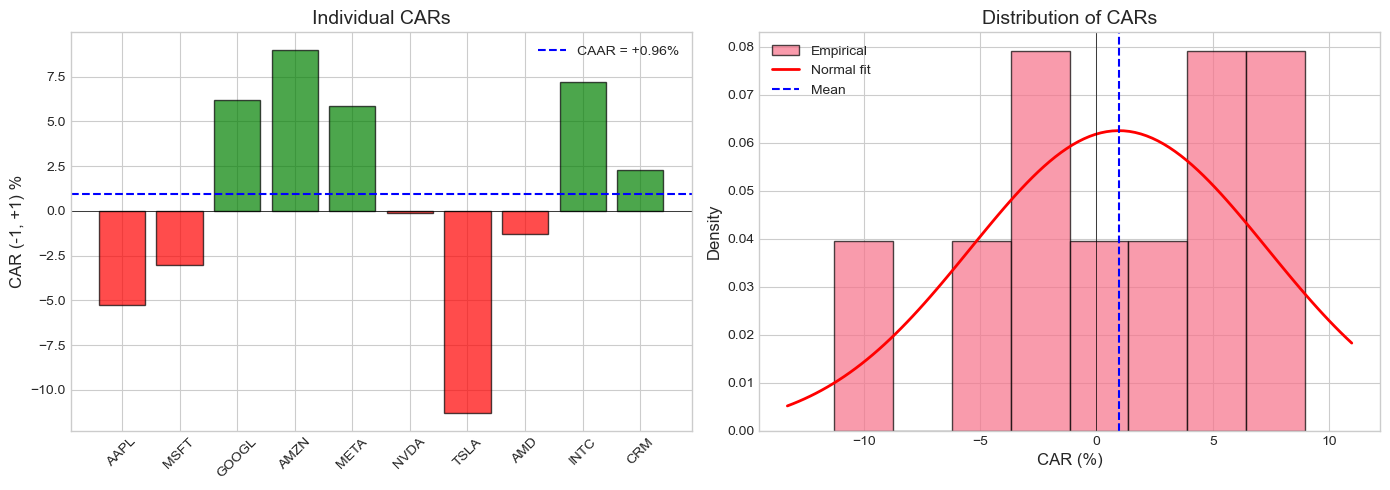

In [10]:
# Visualize individual CARs and distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get CAR(-1,+1) results
result = cs_results[0]  # (-1, +1) window
cars = result['individual_cars']
tickers = [r.ticker for r in event_results]

# Bar chart of individual CARs
ax1 = axes[0]
colors = ['green' if c >= 0 else 'red' for c in cars]
bars = ax1.bar(tickers, cars * 100, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axhline(result['CAAR'] * 100, color='blue', linestyle='--', 
            label=f'CAAR = {result["CAAR"]*100:+.2f}%')
ax1.set_ylabel('CAR (-1, +1) %', fontsize=12)
ax1.set_title('Individual CARs', fontsize=14)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Distribution of CARs
ax2 = axes[1]
ax2.hist(cars * 100, bins=8, density=True, alpha=0.7, edgecolor='black', label='Empirical')

# Overlay normal distribution
x = np.linspace(cars.min()*100 - 2, cars.max()*100 + 2, 100)
y = stats.norm.pdf(x, result['CAAR']*100, result['std_dev']*100)
ax2.plot(x, y, 'r-', linewidth=2, label='Normal fit')

ax2.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax2.axvline(result['CAAR']*100, color='blue', linestyle='--', label='Mean')
ax2.set_xlabel('CAR (%)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of CARs', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Test 2: Time-Series Standard Error Approach

### Alternative Variance Estimation

Instead of using cross-sectional variation, we can use the time-series variance from the estimation period:

$$Var(CAR_i) = L \cdot \sigma^2_{\epsilon_i}$$

Where $L = \tau_2 - \tau_1 + 1$ is the length of the event window.

### Aggregated Test Statistic

$$t_{TS} = \frac{\overline{CAR}}{\sqrt{\frac{1}{N^2}\sum_{i=1}^{N} Var(CAR_i)}}$$

### Comparison

| Approach | Variance Source | Pros | Cons |
|----------|-----------------|------|------|
| Cross-sectional | Event window | Captures heterogeneity | Needs many events |
| Time-series | Estimation window | Works with few events | Assumes stable variance |

In [12]:
def calculate_car_variance_ts(model: MarketModelResults, 
                               event_data: pd.DataFrame,
                               tau1: int, tau2: int) -> float:
    """
    Calculate time-series variance of CAR.
    
    Includes adjustment for estimation error in alpha and beta.
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    window_data = event_data[mask]
    L = len(window_data)
    
    T = model.n_obs
    sigma_sq = model.sigma ** 2
    Rm_bar = model.market_mean
    sum_sq = model.market_var
    
    # Sum of market return deviations in event window
    Rm_event = window_data['market_ret'].values
    sum_dev_sq = np.sum((Rm_event - Rm_bar) ** 2)
    
    # Variance formula (Campbell, Lo, MacKinlay 1997, eq. 4.8)
    var = sigma_sq * (L + L**2/T + sum_dev_sq/sum_sq)
    
    return var


def time_series_t_test(event_results: List[EventStudyResult],
                       tau1: int, tau2: int) -> Dict:
    """
    Time-series variance t-test for CAAR.
    
    Uses estimation period variance instead of cross-sectional variance.
    """
    cars = []
    car_vars = []
    
    for r in event_results:
        car = calculate_car(r.event_data, tau1, tau2)
        var = calculate_car_variance_ts(r.model, r.event_data, tau1, tau2)
        cars.append(car)
        car_vars.append(var)
    
    cars = np.array(cars)
    car_vars = np.array(car_vars)
    N = len(cars)
    
    caar = np.mean(cars)
    
    # Time-series aggregated variance
    # Assuming independence: Var(CAAR) = (1/N^2) * sum(Var(CAR_i))
    var_caar = np.sum(car_vars) / (N ** 2)
    se_caar = np.sqrt(var_caar)
    
    t_stat = caar / se_caar if se_caar > 0 else 0
    
    # Approximate df (conservative)
    df = N * (ESTIMATION_WINDOW - 2)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))
    
    return {
        'test_name': 'Time-Series t-Test',
        'N': N,
        'CAAR': caar,
        'var_caar': var_caar,
        'std_error': se_caar,
        't_stat': t_stat,
        'df': df,
        'p_value': p_value,
        'individual_cars': cars,
        'individual_vars': car_vars
    }


# Compare cross-sectional and time-series tests
print("Cross-Sectional vs Time-Series t-Tests:")
print("="*80)

comparison_data = []
for tau1, tau2 in windows:
    cs = cross_sectional_t_test(event_results, tau1, tau2)
    ts = time_series_t_test(event_results, tau1, tau2)
    
    comparison_data.append({
        'Window': f'[{tau1:+d},{tau2:+d}]',
        'CAAR': cs['CAAR'],
        'CS_SE': cs['std_error'],
        'CS_t': cs['t_stat'],
        'CS_p': cs['p_value'],
        'TS_SE': ts['std_error'],
        'TS_t': ts['t_stat'],
        'TS_p': ts['p_value']
    })

comp_df = pd.DataFrame(comparison_data)

display_comp = comp_df.copy()
display_comp['CAAR'] = display_comp['CAAR'].apply(lambda x: f"{x*100:+.3f}%")
display_comp['CS_SE'] = display_comp['CS_SE'].apply(lambda x: f"{x*100:.3f}%")
display_comp['TS_SE'] = display_comp['TS_SE'].apply(lambda x: f"{x*100:.3f}%")
for col in ['CS_t', 'TS_t']:
    display_comp[col] = display_comp[col].apply(lambda x: f"{x:+.3f}")
for col in ['CS_p', 'TS_p']:
    display_comp[col] = display_comp[col].apply(lambda x: f"{x:.4f}")

print(display_comp.to_string(index=False))
print("\nCS = Cross-Sectional, TS = Time-Series")

Cross-Sectional vs Time-Series t-Tests:
   Window    CAAR  CS_SE   CS_t   CS_p  TS_SE   TS_t   TS_p
  [-1,+1] +0.959% 2.018% +0.475 0.6459 1.271% +0.755 0.4506
  [+0,+0] +0.600% 0.387% +1.550 0.1556 0.727% +0.825 0.4095
  [-5,+5] -0.761% 2.074% -0.367 0.7223 2.509% -0.303 0.7618
[-10,+10] -5.226% 2.508% -2.084 0.0669 3.595% -1.454 0.1463

CS = Cross-Sectional, TS = Time-Series


## 5. Test 3: Patell (1976) Standardized Residual Test

### Motivation

The simple tests treat all firms equally, but firms have different estimation period variances. Patell's test standardizes each firm's abnormal return by its own standard error.

### Standardized Abnormal Return

$$SAR_{i,t} = \frac{AR_{i,t}}{S_{AR_{i,t}}}$$

Where:
$$S_{AR_{i,t}} = \sigma_{\epsilon_i} \sqrt{1 + \frac{1}{T_i} + \frac{(R_{m,t} - \bar{R}_{m,i})^2}{\sum_{k}(R_{m,k} - \bar{R}_{m,i})^2}}$$

### Standardized CAR

$$SCAR_i(\tau_1, \tau_2) = \frac{CAR_i(\tau_1, \tau_2)}{S_{CAR_i}}$$

Where:
$$S_{CAR_i} = \sqrt{\sum_{t=\tau_1}^{\tau_2} S^2_{AR_{i,t}}}$$

### Patell Test Statistic

$$Z_{Patell} = \frac{1}{\sqrt{N}} \sum_{i=1}^{N} SCAR_i \cdot \sqrt{\frac{T_i - 4}{T_i - 2}}$$

Under the null: $Z_{Patell} \xrightarrow{d} N(0, 1)$

In [15]:
def calculate_sar(event_data: pd.DataFrame, model: MarketModelResults) -> np.ndarray:
    """
    Calculate Standardized Abnormal Returns.
    """
    T = model.n_obs
    sigma = model.sigma
    Rm_bar = model.market_mean
    sum_sq = model.market_var
    
    Rm = event_data['market_ret'].values
    AR = event_data['AR'].values
    
    # Standard error for each AR
    S_AR = sigma * np.sqrt(1 + 1/T + (Rm - Rm_bar)**2 / sum_sq)
    
    # Standardized AR
    SAR = AR / S_AR
    
    return SAR, S_AR


def calculate_scar(event_data: pd.DataFrame, model: MarketModelResults,
                   tau1: int, tau2: int) -> Tuple[float, float]:
    """
    Calculate Standardized Cumulative Abnormal Return.
    
    Returns: (SCAR, CAR)
    """
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    window_data = event_data[mask].copy()
    
    _, S_AR = calculate_sar(window_data, model)
    
    CAR = window_data['AR'].sum()
    S_CAR = np.sqrt(np.sum(S_AR**2))
    
    SCAR = CAR / S_CAR if S_CAR > 0 else 0
    
    return SCAR, CAR


def patell_test(event_results: List[EventStudyResult],
                tau1: int, tau2: int) -> Dict:
    """
    Patell (1976) Standardized Residual Test.
    
    Aggregates standardized CARs across firms.
    """
    scars = []
    cars = []
    adjustment_factors = []
    
    for r in event_results:
        scar, car = calculate_scar(r.event_data, r.model, tau1, tau2)
        T = r.model.n_obs
        
        # Patell adjustment factor
        adj = np.sqrt((T - 4) / (T - 2))
        
        scars.append(scar)
        cars.append(car)
        adjustment_factors.append(adj)
    
    scars = np.array(scars)
    cars = np.array(cars)
    adj_factors = np.array(adjustment_factors)
    N = len(scars)
    
    # Patell Z-statistic
    # Z = (1/sqrt(N)) * sum(SCAR_i * adjustment_i)
    Z_patell = np.sum(scars * adj_factors) / np.sqrt(N)
    
    # p-value (standard normal)
    p_value = 2 * (1 - stats.norm.cdf(abs(Z_patell)))
    
    return {
        'test_name': 'Patell (1976)',
        'N': N,
        'CAAR': np.mean(cars),
        'mean_SCAR': np.mean(scars),
        'Z_stat': Z_patell,
        'p_value': p_value,
        'individual_scars': scars,
        'individual_cars': cars
    }


# Run Patell test
print("Patell (1976) Standardized Residual Test:")
print("="*70)

patell_results = []
for tau1, tau2 in windows:
    result = patell_test(event_results, tau1, tau2)
    patell_results.append(result)
    
    sig = '***' if result['p_value'] < 0.01 else '**' if result['p_value'] < 0.05 else '*' if result['p_value'] < 0.10 else ''
    
    print(f"\nWindow [{tau1:+d}, {tau2:+d}]:")
    print(f"  CAAR = {result['CAAR']*100:+.3f}%")
    print(f"  Mean SCAR = {result['mean_SCAR']:+.3f}")
    print(f"  Z-stat = {result['Z_stat']:+.3f} {sig}")
    print(f"  p-value = {result['p_value']:.4f}")

Patell (1976) Standardized Residual Test:

Window [-1, +1]:
  CAAR = +0.959%
  Mean SCAR = +0.175
  Z-stat = +0.550 
  p-value = 0.5825

Window [+0, +0]:
  CAAR = +0.600%
  Mean SCAR = +0.252
  Z-stat = +0.790 
  p-value = 0.4298

Window [-5, +5]:
  CAAR = -0.761%
  Mean SCAR = -0.244
  Z-stat = -0.764 
  p-value = 0.4449

Window [-10, +10]:
  CAAR = -5.226%
  Mean SCAR = -0.592
  Z-stat = -1.858 *
  p-value = 0.0632


## 6. Test 4: Boehmer, Musumeci, and Poulsen (1991) Test

### The Event-Induced Variance Problem

The Patell test can be severely misspecified when events induce changes in variance. If the event increases volatility, Patell's test will over-reject the null.

### BMP Solution

Use the **cross-sectional variance of standardized abnormal returns** instead of assuming unit variance:

$$Z_{BMP} = \frac{\overline{SCAR}}{S_{SCAR}/\sqrt{N}}$$

Where:
- $\overline{SCAR} = \frac{1}{N}\sum_{i=1}^{N} SCAR_i$
- $S_{SCAR} = \sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(SCAR_i - \overline{SCAR})^2}$

### Why It Works

If event-induced variance affects all firms similarly, the cross-sectional variance of SCARs will capture it, providing a more robust test.

In [18]:
def bmp_test(event_results: List[EventStudyResult],
             tau1: int, tau2: int) -> Dict:
    """
    Boehmer, Musumeci, and Poulsen (1991) Test.
    
    Uses cross-sectional standard error of SCARs to account for
    event-induced variance changes.
    """
    scars = []
    cars = []
    
    for r in event_results:
        scar, car = calculate_scar(r.event_data, r.model, tau1, tau2)
        scars.append(scar)
        cars.append(car)
    
    scars = np.array(scars)
    cars = np.array(cars)
    N = len(scars)
    
    # BMP statistic uses cross-sectional variance of SCARs
    mean_scar = np.mean(scars)
    std_scar = np.std(scars, ddof=1)
    se_scar = std_scar / np.sqrt(N)
    
    # Z-statistic
    Z_bmp = mean_scar / se_scar if se_scar > 0 else 0
    
    # Under null with event-induced variance, this should be t-distributed
    p_value = 2 * (1 - stats.t.cdf(abs(Z_bmp), df=N-1))
    
    return {
        'test_name': 'BMP (1991)',
        'N': N,
        'CAAR': np.mean(cars),
        'mean_SCAR': mean_scar,
        'std_SCAR': std_scar,
        'se_SCAR': se_scar,
        't_stat': Z_bmp,
        'df': N - 1,
        'p_value': p_value,
        'individual_scars': scars,
        'individual_cars': cars
    }


# Run BMP test
print("Boehmer-Musumeci-Poulsen (1991) Test:")
print("="*70)

bmp_results = []
for tau1, tau2 in windows:
    result = bmp_test(event_results, tau1, tau2)
    bmp_results.append(result)
    
    sig = '***' if result['p_value'] < 0.01 else '**' if result['p_value'] < 0.05 else '*' if result['p_value'] < 0.10 else ''
    
    print(f"\nWindow [{tau1:+d}, {tau2:+d}]:")
    print(f"  CAAR = {result['CAAR']*100:+.3f}%")
    print(f"  Mean SCAR = {result['mean_SCAR']:+.3f}")
    print(f"  Std. SCAR = {result['std_SCAR']:.3f}")
    print(f"  t-stat = {result['t_stat']:+.3f} {sig}")
    print(f"  p-value = {result['p_value']:.4f}")

Boehmer-Musumeci-Poulsen (1991) Test:

Window [-1, +1]:
  CAAR = +0.959%
  Mean SCAR = +0.175
  Std. SCAR = 2.048
  t-stat = +0.271 
  p-value = 0.7927

Window [+0, +0]:
  CAAR = +0.600%
  Mean SCAR = +0.252
  Std. SCAR = 0.565
  t-stat = +1.410 
  p-value = 0.1923

Window [-5, +5]:
  CAAR = -0.761%
  Mean SCAR = -0.244
  Std. SCAR = 1.335
  t-stat = -0.577 
  p-value = 0.5781

Window [-10, +10]:
  CAAR = -5.226%
  Mean SCAR = -0.592
  Std. SCAR = 1.044
  t-stat = -1.794 
  p-value = 0.1064


In [20]:
# Compare Patell vs BMP
print("\nPatell vs BMP Comparison:")
print("="*80)
print("\nIf Std. SCAR > 1, events are increasing variance (BMP is more conservative)")
print("If Std. SCAR < 1, events are decreasing variance (BMP is more powerful)\n")

pvb_data = []
for i, (tau1, tau2) in enumerate(windows):
    patell = patell_results[i]
    bmp = bmp_results[i]
    
    pvb_data.append({
        'Window': f'[{tau1:+d},{tau2:+d}]',
        'Patell_Z': patell['Z_stat'],
        'Patell_p': patell['p_value'],
        'BMP_t': bmp['t_stat'],
        'BMP_p': bmp['p_value'],
        'Std_SCAR': bmp['std_SCAR'],
        'Variance_Effect': 'Increase' if bmp['std_SCAR'] > 1.1 else 'Decrease' if bmp['std_SCAR'] < 0.9 else 'Neutral'
    })

pvb_df = pd.DataFrame(pvb_data)

display_pvb = pvb_df.copy()
for col in ['Patell_Z', 'BMP_t']:
    display_pvb[col] = display_pvb[col].apply(lambda x: f"{x:+.3f}")
for col in ['Patell_p', 'BMP_p']:
    display_pvb[col] = display_pvb[col].apply(lambda x: f"{x:.4f}")
display_pvb['Std_SCAR'] = display_pvb['Std_SCAR'].apply(lambda x: f"{x:.3f}")

print(display_pvb.to_string(index=False))


Patell vs BMP Comparison:

If Std. SCAR > 1, events are increasing variance (BMP is more conservative)
If Std. SCAR < 1, events are decreasing variance (BMP is more powerful)

   Window Patell_Z Patell_p  BMP_t  BMP_p Std_SCAR Variance_Effect
  [-1,+1]   +0.550   0.5825 +0.271 0.7927    2.048        Increase
  [+0,+0]   +0.790   0.4298 +1.410 0.1923    0.565        Decrease
  [-5,+5]   -0.764   0.4449 -0.577 0.5781    1.335        Increase
[-10,+10]   -1.858   0.0632 -1.794 0.1064    1.044         Neutral


## 7. Test 5: Kolari and Pynnönen (2010) Adjusted BMP

### Cross-Correlation Problem

When events cluster in calendar time, abnormal returns may be cross-sectionally correlated. This violates the independence assumption and inflates test statistics.

### Adjustment

Kolari and Pynnönen (2010) propose adjusting the BMP test for cross-correlation:

$$t_{ADJ} = t_{BMP} \cdot \sqrt{\frac{1 - \bar{r}}{1 + (N-1)\bar{r}}}$$

Where $\bar{r}$ is the average cross-correlation of abnormal returns in the estimation period.

In [23]:
def estimate_cross_correlation(event_results: List[EventStudyResult]) -> float:
    """
    Estimate average cross-correlation of residuals.
    
    Uses estimation period residuals to estimate cross-sectional correlation.
    """
    # Collect residuals (may have different lengths/dates, so we use pairwise correlation)
    residuals_list = [r.model.residuals for r in event_results]
    N = len(residuals_list)
    
    if N < 2:
        return 0.0
    
    # Calculate pairwise correlations
    correlations = []
    for i in range(N):
        for j in range(i+1, N):
            # Use minimum common length
            min_len = min(len(residuals_list[i]), len(residuals_list[j]))
            if min_len > 10:
                corr = np.corrcoef(residuals_list[i][:min_len], 
                                   residuals_list[j][:min_len])[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
    
    return np.mean(correlations) if correlations else 0.0


def kolari_pynnonen_test(event_results: List[EventStudyResult],
                         tau1: int, tau2: int) -> Dict:
    """
    Kolari and Pynnönen (2010) adjusted BMP test.
    
    Adjusts for cross-sectional correlation of abnormal returns.
    """
    # First get BMP results
    bmp = bmp_test(event_results, tau1, tau2)
    N = bmp['N']
    t_bmp = bmp['t_stat']
    
    # Estimate cross-correlation
    r_bar = estimate_cross_correlation(event_results)
    
    # Adjustment factor
    if r_bar >= 1/(1-N):  # Avoid negative under radical
        adj_factor = 0.01  # Very small adjustment
    else:
        adj_factor = np.sqrt((1 - r_bar) / (1 + (N-1) * r_bar))
    
    # Adjusted t-statistic
    t_adj = t_bmp * adj_factor
    
    # p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_adj), df=N-1))
    
    return {
        'test_name': 'Kolari-Pynnönen (2010)',
        'N': N,
        'CAAR': bmp['CAAR'],
        'mean_SCAR': bmp['mean_SCAR'],
        't_BMP': t_bmp,
        'r_bar': r_bar,
        'adj_factor': adj_factor,
        't_adjusted': t_adj,
        'p_value': p_value
    }


# Run Kolari-Pynnönen test
print("Kolari-Pynnönen (2010) Adjusted Test:")
print("="*70)

# First show cross-correlation estimate
r_bar = estimate_cross_correlation(event_results)
print(f"\nEstimated average cross-correlation: {r_bar:.4f}")
print("(High correlation requires larger adjustment)\n")

kp_results = []
for tau1, tau2 in windows:
    result = kolari_pynnonen_test(event_results, tau1, tau2)
    kp_results.append(result)
    
    sig = '***' if result['p_value'] < 0.01 else '**' if result['p_value'] < 0.05 else '*' if result['p_value'] < 0.10 else ''
    
    print(f"Window [{tau1:+d}, {tau2:+d}]:")
    print(f"  BMP t-stat = {result['t_BMP']:+.3f}")
    print(f"  Adjustment factor = {result['adj_factor']:.3f}")
    print(f"  Adjusted t-stat = {result['t_adjusted']:+.3f} {sig}")
    print(f"  p-value = {result['p_value']:.4f}\n")

Kolari-Pynnönen (2010) Adjusted Test:

Estimated average cross-correlation: 0.0203
(High correlation requires larger adjustment)

Window [-1, +1]:
  BMP t-stat = +0.271
  Adjustment factor = 0.010
  Adjusted t-stat = +0.003 
  p-value = 0.9979

Window [+0, +0]:
  BMP t-stat = +1.410
  Adjustment factor = 0.010
  Adjusted t-stat = +0.014 
  p-value = 0.9891

Window [-5, +5]:
  BMP t-stat = -0.577
  Adjustment factor = 0.010
  Adjusted t-stat = -0.006 
  p-value = 0.9955

Window [-10, +10]:
  BMP t-stat = -1.794
  Adjustment factor = 0.010
  Adjusted t-stat = -0.018 
  p-value = 0.9861



## 8. Comprehensive Test Comparison

Let's compare all parametric tests side by side.

In [26]:
def run_all_parametric_tests(event_results: List[EventStudyResult],
                              tau1: int, tau2: int) -> pd.DataFrame:
    """
    Run all parametric tests and return comparison table.
    """
    cs = cross_sectional_t_test(event_results, tau1, tau2)
    ts = time_series_t_test(event_results, tau1, tau2)
    patell = patell_test(event_results, tau1, tau2)
    bmp = bmp_test(event_results, tau1, tau2)
    kp = kolari_pynnonen_test(event_results, tau1, tau2)
    
    results = [
        {'Test': 'Cross-Sectional t', 'Statistic': cs['t_stat'], 'p-value': cs['p_value']},
        {'Test': 'Time-Series t', 'Statistic': ts['t_stat'], 'p-value': ts['p_value']},
        {'Test': 'Patell Z', 'Statistic': patell['Z_stat'], 'p-value': patell['p_value']},
        {'Test': 'BMP t', 'Statistic': bmp['t_stat'], 'p-value': bmp['p_value']},
        {'Test': 'Kolari-Pynnönen t', 'Statistic': kp['t_adjusted'], 'p-value': kp['p_value']},
    ]
    
    return pd.DataFrame(results)


# Create comprehensive comparison
print("\n" + "="*90)
print("COMPREHENSIVE PARAMETRIC TEST COMPARISON")
print("="*90)

for tau1, tau2 in windows:
    print(f"\n\nWindow [{tau1:+d}, {tau2:+d}]")
    print("-" * 60)
    
    # Get CAAR for reference
    cars = [calculate_car(r.event_data, tau1, tau2) for r in event_results]
    caar = np.mean(cars)
    print(f"CAAR = {caar*100:+.3f}%  (N = {len(event_results)})\n")
    
    results = run_all_parametric_tests(event_results, tau1, tau2)
    
    # Add significance markers
    def sig_marker(p):
        if p < 0.01: return '***'
        elif p < 0.05: return '**'
        elif p < 0.10: return '*'
        else: return ''
    
    results['Sig'] = results['p-value'].apply(sig_marker)
    results['Statistic'] = results['Statistic'].apply(lambda x: f"{x:+.3f}")
    results['p-value'] = results['p-value'].apply(lambda x: f"{x:.4f}")
    
    print(results.to_string(index=False))


COMPREHENSIVE PARAMETRIC TEST COMPARISON


Window [-1, +1]
------------------------------------------------------------
CAAR = +0.959%  (N = 10)

             Test Statistic p-value Sig
Cross-Sectional t    +0.475  0.6459    
    Time-Series t    +0.755  0.4506    
         Patell Z    +0.550  0.5825    
            BMP t    +0.271  0.7927    
Kolari-Pynnönen t    +0.003  0.9979    


Window [+0, +0]
------------------------------------------------------------
CAAR = +0.600%  (N = 10)

             Test Statistic p-value Sig
Cross-Sectional t    +1.550  0.1556    
    Time-Series t    +0.825  0.4095    
         Patell Z    +0.790  0.4298    
            BMP t    +1.410  0.1923    
Kolari-Pynnönen t    +0.014  0.9891    


Window [-5, +5]
------------------------------------------------------------
CAAR = -0.761%  (N = 10)

             Test Statistic p-value Sig
Cross-Sectional t    -0.367  0.7223    
    Time-Series t    -0.303  0.7618    
         Patell Z    -0.764  0.4449    
   

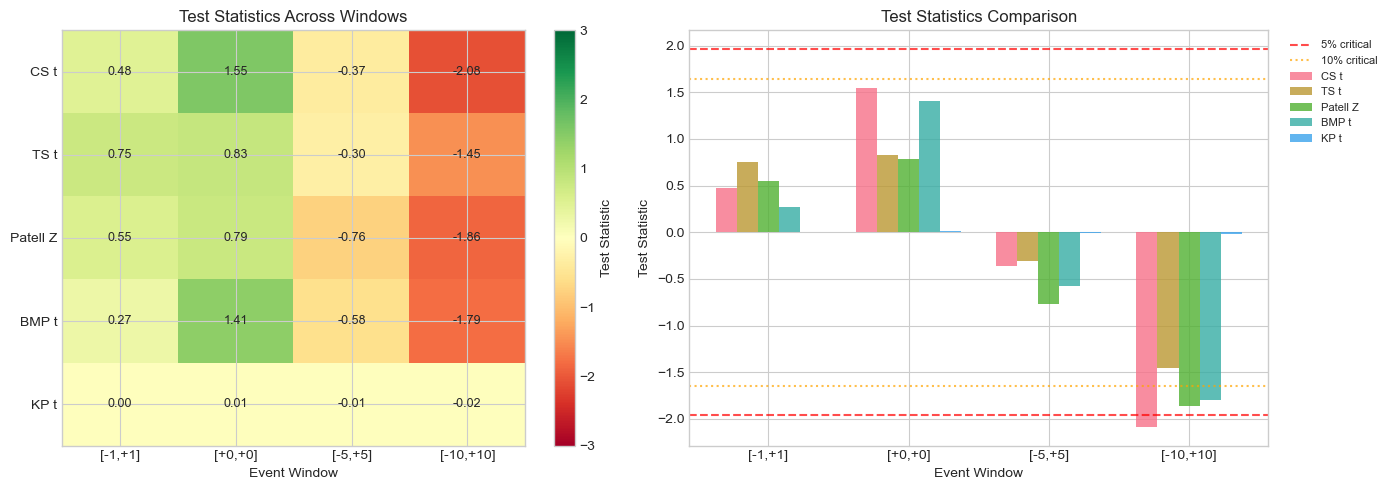

In [28]:
# Visualize test statistics comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Collect test statistics for all windows
test_names = ['CS t', 'TS t', 'Patell Z', 'BMP t', 'KP t']
window_labels = [f'[{t1:+d},{t2:+d}]' for t1, t2 in windows]

stats_matrix = np.zeros((len(windows), len(test_names)))

for i, (tau1, tau2) in enumerate(windows):
    cs = cross_sectional_t_test(event_results, tau1, tau2)
    ts = time_series_t_test(event_results, tau1, tau2)
    patell = patell_test(event_results, tau1, tau2)
    bmp = bmp_test(event_results, tau1, tau2)
    kp = kolari_pynnonen_test(event_results, tau1, tau2)
    
    stats_matrix[i, :] = [cs['t_stat'], ts['t_stat'], patell['Z_stat'], 
                          bmp['t_stat'], kp['t_adjusted']]

# Heatmap of test statistics
ax1 = axes[0]
im = ax1.imshow(stats_matrix.T, cmap='RdYlGn', aspect='auto', vmin=-3, vmax=3)
ax1.set_xticks(range(len(windows)))
ax1.set_xticklabels(window_labels)
ax1.set_yticks(range(len(test_names)))
ax1.set_yticklabels(test_names)
ax1.set_xlabel('Event Window')
ax1.set_title('Test Statistics Across Windows')

# Add value annotations
for i in range(len(test_names)):
    for j in range(len(windows)):
        ax1.text(j, i, f'{stats_matrix[j, i]:.2f}', ha='center', va='center', fontsize=9)

plt.colorbar(im, ax=ax1, label='Test Statistic')

# Critical value lines for reference
ax2 = axes[1]
x = np.arange(len(windows))
width = 0.15

for i, test in enumerate(test_names):
    ax2.bar(x + i*width, stats_matrix[:, i], width, label=test, alpha=0.8)

ax2.axhline(1.96, color='red', linestyle='--', alpha=0.7, label='5% critical')
ax2.axhline(-1.96, color='red', linestyle='--', alpha=0.7)
ax2.axhline(1.645, color='orange', linestyle=':', alpha=0.7, label='10% critical')
ax2.axhline(-1.645, color='orange', linestyle=':', alpha=0.7)

ax2.set_xticks(x + 2*width)
ax2.set_xticklabels(window_labels)
ax2.set_xlabel('Event Window')
ax2.set_ylabel('Test Statistic')
ax2.set_title('Test Statistics Comparison')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

## 9. Power Analysis: Monte Carlo Simulation

### Understanding Test Power

**Power** = Probability of rejecting $H_0$ when it is false

We want tests with:
- Correct **size** (reject at stated significance level under $H_0$)
- High **power** (detect true effects)

### Simulation Setup

1. Generate synthetic abnormal returns with known properties
2. Apply different tests
3. Measure rejection rates under $H_0$ (size) and $H_1$ (power)

In [31]:
def simulate_event_study(N: int, T_est: int, L_event: int,
                         true_car: float = 0.0,
                         sigma: float = 0.02,
                         event_variance_multiplier: float = 1.0) -> List[Dict]:
    """
    Simulate event study data for power analysis.
    
    Parameters:
    -----------
    N : int
        Number of events
    T_est : int
        Estimation window length
    L_event : int
        Event window length
    true_car : float
        True cumulative abnormal return (0 under null)
    sigma : float
        Residual standard deviation
    event_variance_multiplier : float
        Multiplier for event window variance (>1 means event-induced variance)
    
    Returns:
    --------
    List of simulated event results
    """
    results = []
    
    # True abnormal return per day (spread evenly)
    true_ar_daily = true_car / L_event
    
    for i in range(N):
        # Generate estimation period residuals
        est_residuals = np.random.normal(0, sigma, T_est)
        
        # Generate event window abnormal returns
        event_sigma = sigma * np.sqrt(event_variance_multiplier)
        event_ar = np.random.normal(true_ar_daily, event_sigma, L_event)
        
        # Create mock model
        model = MarketModelResults(
            alpha=0.0,
            beta=1.0,
            sigma=np.std(est_residuals, ddof=2),
            r_squared=0.3,
            n_obs=T_est,
            market_mean=0.0005,
            market_var=T_est * 0.0001,
            residuals=est_residuals
        )
        
        # Create event data
        event_data = pd.DataFrame({
            'event_time': range(-L_event//2, L_event//2 + L_event%2),
            'stock_ret': event_ar + 0.0005,  # Add expected return
            'market_ret': np.random.normal(0.0005, 0.01, L_event),
            'expected_ret': np.full(L_event, 0.0005),
            'AR': event_ar
        })
        
        results.append({
            'model': model,
            'event_data': event_data
        })
    
    return results


def run_simulation_tests(sim_results: List[Dict], tau1: int, tau2: int) -> Dict:
    """
    Run all tests on simulated data.
    """
    # Convert to format expected by test functions
    class MockResult:
        def __init__(self, d):
            self.model = d['model']
            self.event_data = d['event_data']
    
    mock_results = [MockResult(d) for d in sim_results]
    
    cs = cross_sectional_t_test(mock_results, tau1, tau2)
    patell = patell_test(mock_results, tau1, tau2)
    bmp = bmp_test(mock_results, tau1, tau2)
    
    return {
        'CS_p': cs['p_value'],
        'Patell_p': patell['p_value'],
        'BMP_p': bmp['p_value']
    }


def monte_carlo_power(N_events: int, N_sims: int, true_car: float,
                      event_var_mult: float = 1.0, 
                      alpha: float = 0.05) -> Dict:
    """
    Monte Carlo simulation for test power/size.
    """
    rejections = {'CS': 0, 'Patell': 0, 'BMP': 0}
    
    for _ in range(N_sims):
        sim_data = simulate_event_study(
            N=N_events, T_est=120, L_event=3,
            true_car=true_car, sigma=0.02,
            event_variance_multiplier=event_var_mult
        )
        
        results = run_simulation_tests(sim_data, -1, 1)
        
        if results['CS_p'] < alpha:
            rejections['CS'] += 1
        if results['Patell_p'] < alpha:
            rejections['Patell'] += 1
        if results['BMP_p'] < alpha:
            rejections['BMP'] += 1
    
    return {
        'CS_rejection_rate': rejections['CS'] / N_sims,
        'Patell_rejection_rate': rejections['Patell'] / N_sims,
        'BMP_rejection_rate': rejections['BMP'] / N_sims
    }


print("Monte Carlo Simulation: Test Size and Power")
print("="*70)
print("(This may take a moment...)\n")

N_SIMS = 500  # Reduced for speed; use 1000+ for research
N_EVENTS = 30

# Test size under H0 (true_car = 0)
print("1. SIZE (H0: CAR = 0, No event-induced variance)")
size_results = monte_carlo_power(N_EVENTS, N_SIMS, true_car=0.0, event_var_mult=1.0)
print(f"   CS t-test:    {size_results['CS_rejection_rate']*100:.1f}% (nominal: 5%)")
print(f"   Patell test:  {size_results['Patell_rejection_rate']*100:.1f}%")
print(f"   BMP test:     {size_results['BMP_rejection_rate']*100:.1f}%")

# Test size with event-induced variance
print("\n2. SIZE WITH EVENT-INDUCED VARIANCE (H0: CAR = 0, Variance x2)")
size_eiv = monte_carlo_power(N_EVENTS, N_SIMS, true_car=0.0, event_var_mult=2.0)
print(f"   CS t-test:    {size_eiv['CS_rejection_rate']*100:.1f}%")
print(f"   Patell test:  {size_eiv['Patell_rejection_rate']*100:.1f}% <- Over-rejects!")
print(f"   BMP test:     {size_eiv['BMP_rejection_rate']*100:.1f}% <- Robust")

# Test power
print("\n3. POWER (H1: CAR = 1%)")
power_results = monte_carlo_power(N_EVENTS, N_SIMS, true_car=0.01, event_var_mult=1.0)
print(f"   CS t-test:    {power_results['CS_rejection_rate']*100:.1f}%")
print(f"   Patell test:  {power_results['Patell_rejection_rate']*100:.1f}%")
print(f"   BMP test:     {power_results['BMP_rejection_rate']*100:.1f}%")

Monte Carlo Simulation: Test Size and Power
(This may take a moment...)

1. SIZE (H0: CAR = 0, No event-induced variance)


ValueError: All arrays must be of the same length

In [33]:
# Power curve as function of true CAR
print("\nGenerating power curves (this may take a minute)...")

true_cars = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
power_data = {'CAR': [], 'CS': [], 'Patell': [], 'BMP': []}

for car in true_cars:
    result = monte_carlo_power(N_EVENTS, 300, true_car=car)
    power_data['CAR'].append(car * 100)
    power_data['CS'].append(result['CS_rejection_rate'] * 100)
    power_data['Patell'].append(result['Patell_rejection_rate'] * 100)
    power_data['BMP'].append(result['BMP_rejection_rate'] * 100)
    print(f"  CAR = {car*100:.1f}%: CS={result['CS_rejection_rate']*100:.0f}%, "
          f"Patell={result['Patell_rejection_rate']*100:.0f}%, "
          f"BMP={result['BMP_rejection_rate']*100:.0f}%")

# Plot power curves
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(power_data['CAR'], power_data['CS'], 'b-o', label='CS t-test', markersize=8)
ax.plot(power_data['CAR'], power_data['Patell'], 'g-s', label='Patell', markersize=8)
ax.plot(power_data['CAR'], power_data['BMP'], 'r-^', label='BMP', markersize=8)

ax.axhline(5, color='gray', linestyle='--', alpha=0.7, label='5% significance')
ax.axhline(80, color='gray', linestyle=':', alpha=0.7, label='80% power target')

ax.set_xlabel('True CAR (%)', fontsize=12)
ax.set_ylabel('Rejection Rate (%)', fontsize=12)
ax.set_title(f'Power Curves (N={N_EVENTS} events, 5% significance)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()


Generating power curves (this may take a minute)...


ValueError: All arrays must be of the same length

## 10. Practical Guidelines

### Which Test to Use?

| Situation | Recommended Test | Reason |
|-----------|------------------|--------|
| General use | BMP | Robust to event-induced variance |
| No event clustering | Patell | More powerful when assumptions hold |
| Event clustering | Kolari-Pynnönen | Adjusts for cross-correlation |
| Very small sample (N<10) | Cross-sectional t | Simple, interpretable |
| Heterogeneous firms | BMP or KP | Account for variance differences |

### Reporting Best Practices

1. **Report multiple tests** for robustness
2. **Include both CAAR and test statistics**
3. **Note sample size** and any clustering
4. **Report results for multiple windows**
5. **Discuss economic vs. statistical significance**

In [35]:
def create_publication_table(event_results: List[EventStudyResult],
                              windows: List[Tuple[int, int]]) -> pd.DataFrame:
    """
    Create a publication-ready results table.
    """
    rows = []
    
    for tau1, tau2 in windows:
        cars = [calculate_car(r.event_data, tau1, tau2) for r in event_results]
        caar = np.mean(cars)
        
        cs = cross_sectional_t_test(event_results, tau1, tau2)
        patell = patell_test(event_results, tau1, tau2)
        bmp = bmp_test(event_results, tau1, tau2)
        
        def sig(p):
            if p < 0.01: return '***'
            elif p < 0.05: return '**'
            elif p < 0.10: return '*'
            return ''
        
        rows.append({
            'Window': f'[{tau1:+d}, {tau2:+d}]',
            'N': len(event_results),
            'CAAR (%)': f"{caar*100:+.2f}",
            'CS t-stat': f"{cs['t_stat']:.2f}{sig(cs['p_value'])}",
            'Patell Z': f"{patell['Z_stat']:.2f}{sig(patell['p_value'])}",
            'BMP t-stat': f"{bmp['t_stat']:.2f}{sig(bmp['p_value'])}"
        })
    
    return pd.DataFrame(rows)


# Generate publication table
print("\n" + "="*90)
print("PUBLICATION-READY RESULTS TABLE")
print("="*90)
print("\nTable: Cumulative Average Abnormal Returns Around Earnings Announcements")
print("Sample: Tech companies, Q2-Q3 2023 earnings")
print("-"*90)

pub_table = create_publication_table(event_results, windows)
print(pub_table.to_string(index=False))

print("-"*90)
print("Notes: ***, **, * indicate significance at 1%, 5%, 10% levels.")
print("CS = cross-sectional t-test; Patell = Patell (1976) standardized test;")
print("BMP = Boehmer et al. (1991) standardized cross-sectional test.")


PUBLICATION-READY RESULTS TABLE

Table: Cumulative Average Abnormal Returns Around Earnings Announcements
Sample: Tech companies, Q2-Q3 2023 earnings
------------------------------------------------------------------------------------------
    Window  N CAAR (%) CS t-stat Patell Z BMP t-stat
  [-1, +1] 10    +0.96      0.48     0.55       0.27
  [+0, +0] 10    +0.60      1.55     0.79       1.41
  [-5, +5] 10    -0.76     -0.37    -0.76      -0.58
[-10, +10] 10    -5.23    -2.08*   -1.86*      -1.79
------------------------------------------------------------------------------------------
Notes: ***, **, * indicate significance at 1%, 5%, 10% levels.
CS = cross-sectional t-test; Patell = Patell (1976) standardized test;
BMP = Boehmer et al. (1991) standardized cross-sectional test.


## 11. Exercises

### Exercise 1: Sample Size Sensitivity
Using Monte Carlo simulation, examine how test power changes with sample size (N = 10, 30, 50, 100).

### Exercise 2: Window Length Effects
How does test power change as you lengthen the event window? Why?

### Exercise 3: Skewness Adjustment
Implement a skewness-adjusted t-test that accounts for non-normality in CARs.

### Exercise 4: Calendar-Time Portfolio
Implement a calendar-time portfolio approach that forms portfolios of event firms and regresses on market factors.

In [37]:
# Exercise 3 Template: Skewness-Adjusted t-Test

def skewness_adjusted_t_test(event_results: List[EventStudyResult],
                              tau1: int, tau2: int) -> Dict:
    """
    Hall (1992) skewness-adjusted t-test.
    
    Adjusts for skewness in the CAR distribution.
    """
    cars = np.array([calculate_car(r.event_data, tau1, tau2) for r in event_results])
    N = len(cars)
    
    # Standard t-test components
    mean_car = np.mean(cars)
    std_car = np.std(cars, ddof=1)
    se = std_car / np.sqrt(N)
    t_standard = mean_car / se if se > 0 else 0
    
    # Skewness
    skew = stats.skew(cars)
    
    # Hall (1992) adjustment
    # t_adj = t + (1/6) * skew * (t^2 + 2) / sqrt(N)
    t_adjusted = t_standard + (1/6) * skew * (t_standard**2 + 2) / np.sqrt(N)
    
    p_value = 2 * (1 - stats.t.cdf(abs(t_adjusted), df=N-1))
    
    return {
        'test_name': 'Skewness-Adjusted t',
        'N': N,
        'CAAR': mean_car,
        'skewness': skew,
        't_standard': t_standard,
        't_adjusted': t_adjusted,
        'p_value': p_value
    }


# Test the skewness-adjusted t-test
print("Skewness-Adjusted t-Test:")
print("="*50)

for tau1, tau2 in [(-1, +1), (0, 0)]:
    result = skewness_adjusted_t_test(event_results, tau1, tau2)
    print(f"\nWindow [{tau1:+d}, {tau2:+d}]:")
    print(f"  Skewness = {result['skewness']:.3f}")
    print(f"  Standard t = {result['t_standard']:.3f}")
    print(f"  Adjusted t = {result['t_adjusted']:.3f}")
    print(f"  p-value = {result['p_value']:.4f}")

Skewness-Adjusted t-Test:

Window [-1, +1]:
  Skewness = -0.507
  Standard t = 0.475
  Adjusted t = 0.416
  p-value = 0.6873

Window [+0, +0]:
  Skewness = -0.001
  Standard t = 1.550
  Adjusted t = 1.550
  p-value = 0.1556


## 12. Summary

In this session, we covered:

1. **Cross-Sectional t-Test**: Simple but assumes homogeneous variance

2. **Time-Series t-Test**: Uses estimation period variance

3. **Patell (1976) Test**: Standardizes ARs, more powerful but assumes no event-induced variance

4. **BMP (1991) Test**: Robust to event-induced variance changes

5. **Kolari-Pynnönen (2010)**: Adjusts for cross-correlation

6. **Monte Carlo Analysis**: Understanding test size and power

### Key Takeaways

- **BMP is the recommended default** for most applications
- Event-induced variance is common and Patell over-rejects
- Cross-correlation from event clustering requires adjustment
- Report multiple tests for robustness
- Consider economic significance alongside statistical significance

### Coming Up Next

**Session 5: Statistical Inference II - Non-Parametric and Robust Tests** will cover:
- Sign test and generalized sign test
- Rank tests (Corrado, Corrado-Zivney)
- Bootstrap methods
- Dealing with non-normality

## 13. References

### Core Methodology
- Patell, J. M. (1976). Corporate forecasts of earnings per share and stock price behavior. *Journal of Accounting Research*, 14(2), 246-276.
- Boehmer, E., Musumeci, J., & Poulsen, A. B. (1991). Event-study methodology under conditions of event-induced variance. *Journal of Financial Economics*, 30(2), 253-272.
- Kolari, J. W., & Pynnönen, S. (2010). Event study testing with cross-sectional correlation of abnormal returns. *Review of Financial Studies*, 23(11), 3996-4025.

### Power and Specification
- Brown, S. J., & Warner, J. B. (1985). Using daily stock returns: The case of event studies. *Journal of Financial Economics*, 14(1), 3-31.
- Campbell, J. Y., Lo, A. W., & MacKinlay, A. C. (1997). *The Econometrics of Financial Markets*. Princeton University Press.